In [1]:
# Importing necessary libraries
from matplotlib import pyplot as plt
import os
import numpy as np
import csv
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold



In [2]:
# Loading data and mapping filenames to indices
print("Loading data...")
train_dir = 'data/train'
emotions = os.listdir(train_dir)
X_train, y_train = [], []
index_to_filename = []

for emotion in emotions:
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        img_path = os.path.join(emotion_dir, img_file)
        img = load_img(img_path, target_size=(100, 100), color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        X_train.append(img_array)
        y_train.append(emotions.index(emotion))
        index_to_filename.append((img_file, emotion))  # Store the filename and emotion

X_train = np.array(X_train)
y_train = to_categorical(y_train, num_classes=len(emotions))
print("Data loaded successfully.")

Loading data...
Data loaded successfully.


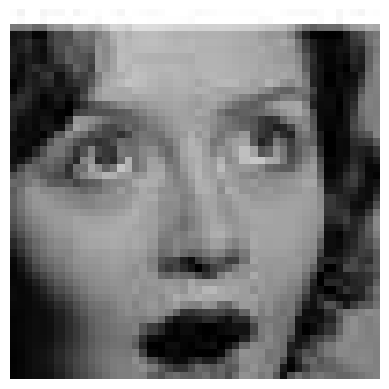

surprise


In [3]:
# plot example image
img_number = 8001
plt.imshow(X_train[img_number].reshape(100, 100), cmap='gray')
plt.axis('off')
plt.show()

#print label of the image
print(emotions[np.argmax(y_train[img_number])])

In [4]:
# Split the data into train and validation sets
print("Splitting data into train and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Data split complete.")

Splitting data into train and validation sets...
Data split complete.


In [5]:
# Reshape the data for CNN input
print("Reshaping data for CNN input...")
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 1)
print("Reshaping complete.")

Reshaping data for CNN input...
Reshaping complete.


In [6]:
# Check the shape of the data
print("Shape Train: ",X_train.shape)
print("Shape Val: ",X_val.shape)

Shape Train:  (7286, 100, 100, 1)
Shape Val:  (1822, 100, 100, 1)


In [22]:
# Data augmentation
# Note that augmented data is not stored in x_train, but is generated on the fly during training
print("Setting up data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)
print("Data augmentation setup complete.")

Setting up data augmentation...
Data augmentation setup complete.


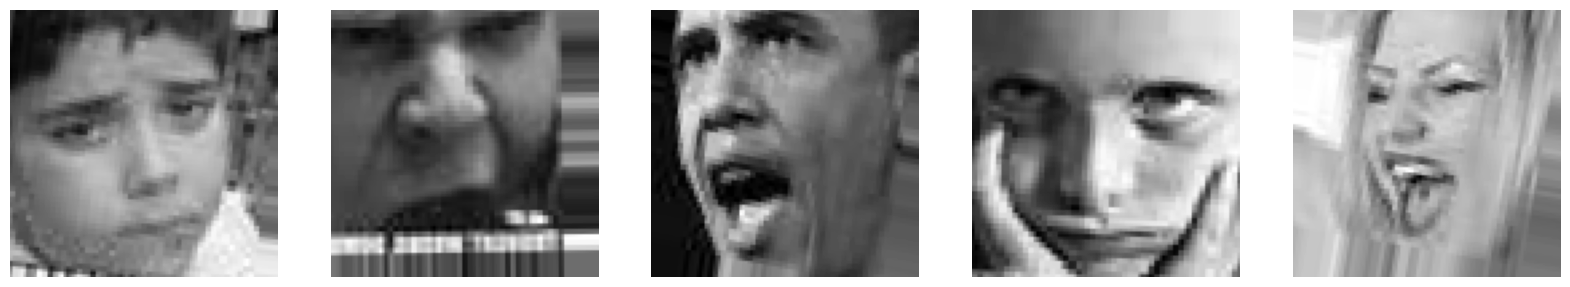

In [23]:
import matplotlib.pyplot as plt

# Create a generator that will provide augmented images
augmented_images, _ = next(datagen.flow(X_train, y_train, batch_size=5))

# Plot the augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].imshow(augmented_images[i].reshape(100, 100), cmap='gray')
    axes[i].axis('off')
plt.show()

In [24]:
# Build the enhanced model
def create_model():
    print("Building the model...")
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(emotions), activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Model built successfully.")
    return model

In [25]:
# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
validation_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = create_model()

    # Define callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

    # Train the model with data augmentation
    print("Starting model training...")
    history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                        validation_data=(X_val, y_val),
                        epochs=50,
                        callbacks=[early_stop, reduce_lr])
    print("Model trained successfully.")

    val_score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    validation_scores.append(val_score)
    
print("Validation scores:", validation_scores)
print("Mean validation score:", np.mean(validation_scores))

Building the model...
Model built successfully.
Starting model training...
Epoch 1/50
114/114 [==============================] - 16s 131ms/step - loss: 3.4443 - accuracy: 0.2723 - val_loss: 3.2283 - val_accuracy: 0.2393 - lr: 0.0010
Epoch 2/50
114/114 [==============================] - 14s 125ms/step - loss: 3.0097 - accuracy: 0.3210 - val_loss: 4.0838 - val_accuracy: 0.2223 - lr: 0.0010
Epoch 3/50
114/114 [==============================] - 15s 128ms/step - loss: 2.7127 - accuracy: 0.3770 - val_loss: 3.1732 - val_accuracy: 0.2788 - lr: 0.0010
Epoch 4/50
114/114 [==============================] - 14s 125ms/step - loss: 2.4540 - accuracy: 0.4319 - val_loss: 3.4015 - val_accuracy: 0.2223 - lr: 0.0010
Epoch 5/50
114/114 [==============================] - 15s 130ms/step - loss: 2.2373 - accuracy: 0.4760 - val_loss: 2.1876 - val_accuracy: 0.4846 - lr: 0.0010
Epoch 6/50
114/114 [==============================] - 15s 127ms/step - loss: 2.0922 - accuracy: 0.5150 - val_loss: 2.1107 - val_accurac

KeyboardInterrupt: 

In [126]:
# Make predictions on the test set
print("Making predictions on the test set...")
test_dir = 'data/test'
X_test = []
test_filenames = []
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    img = load_img(img_path, target_size=(100, 100), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    X_test.append(img_array)
    test_filenames.append(img_file)

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)
y_pred = model.predict(X_test)
predicted_labels = [emotions[np.argmax(prob)] for prob in y_pred]
print("Predictions made successfully.")

Making predictions on the test set...
75/75 [==============================] - 1s 18ms/step
Predictions made successfully.


In [127]:
# Store predictions in a CSV file
print("Saving predictions to CSV file...")
with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id', 'emotions'])
    for filename, label in zip(test_filenames, predicted_labels):
        writer.writerow([filename, label])
print("Predictions saved to submission.csv.")

Saving predictions to CSV file...
Predictions saved to submission.csv.


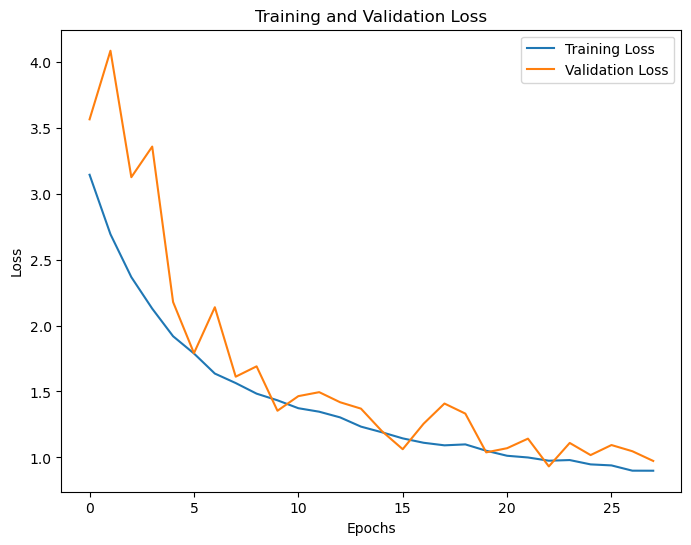

In [128]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()